In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from os import listdir
from os.path import isfile, join
import numpy as np 
import tensorflow as tf
from PIL import Image as img
from tensorflow.python import keras
from keras import Sequential, datasets, layers, models
import pickle as pk

In [2]:
pixels = 150
dimensions = (pixels, pixels)
bins = 5
mid_layer = 512
num_epochs = 3
learning_rate = 0.001
reduction_factor = 0.7

In [3]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        old_lr = self.model.optimizer.lr.read_value()
        new_lr = old_lr * reduction_factor
        print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
        self.model.optimizer.lr.assign(new_lr)

In [4]:
train_images = []
train_labels = np.array([])

folder_path = '/mnt/c/NN/Diabetic Retinopathy/'

for i in range(5):
    list_dir = listdir(folder_path + str(i))
    list_dir = [f for f in list_dir]
    list_dir = sorted(list_dir)
    for j in range(0, 708):
        im = img.open(folder_path + str(i) + '/' + list_dir[j])
        im = im.resize(dimensions)
        im = im.convert('L')
        im_array = np.array(im)
        im.close()
        train_images.append(im_array)
        train_labels = np.append(train_labels, i)

In [5]:
train_images = np.array(train_images)
# train_images = np.reshape(train_images, (354, pixels, 2 * pixels, 5))
# train_labels = np.reshape(train_labels, (5, 354))

In [6]:
print(np.shape(train_images))
print(np.shape(train_labels))

(1770, 150, 300)
(1770,)


In [7]:
randomize = np.arange(len(train_images))
np.random.shuffle(randomize)
train_images = train_images[randomize]
train_labels = train_labels[randomize]

test_images = train_images[int(len(train_labels) * 0.8):, :, :]
test_labels = train_labels[int(len(train_labels) * 0.8):]

train_images = train_images[:int(len(train_labels) * 0.8), :, :]
train_labels = train_labels[:int(len(train_labels) * 0.8)]

train_images = np.squeeze(train_images) / 255.0
test_images = np.squeeze(test_images) / 255.0

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

# train_images = np.squeeze(np.reshape(train_images, (len(train_images) * 5, pixels, 2 * pixels))) / 255.0
# train_labels = np.squeeze(np.reshape(train_labels, len(train_labels) * 5))
# test_images = np.squeeze(np.reshape(test_images, (len(test_images) * 5, pixels, 2 * pixels))) / 255.0
# test_labels = np.squeeze(np.reshape(test_labels, len(test_labels) * 5))

In [8]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(1416, 150, 300)
(1416,)
(354, 150, 300)
(354,)


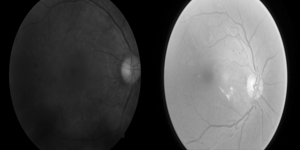

3.0


In [13]:
img.fromarray(255 * train_images[0]).show()
print(train_labels[0])

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(pixels, 2 * pixels, 1)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
# model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Flatten())
model.add(layers.Dense(mid_layer, activation='relu'))
model.add(layers.Dense(bins, activation='relu'))

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [11]:
history = model.fit(train_images, train_labels, callbacks=[LearningRateReducerCb()], epochs=num_epochs, validation_data=(test_images, test_labels))

Epoch 1/3
45/45 [==============================] - ETA: 0s - loss: 1.7228 - accuracy: 0.2062
Epoch: 0. Reducing Learning Rate from 0.0010000000474974513 to 0.0007000000332482159
45/45 [==============================] - 15s 319ms/step - loss: 1.7228 - accuracy: 0.2062 - val_loss: 1.6094 - val_accuracy: 0.1723
Epoch 2/3
25/45 [===============>..............] - ETA: 6s - loss: 1.6094 - accuracy: 0.2062

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print("Accuracy = " + str(np.round(test_acc * 100, 3)) + " %")

In [ ]:
filename = 'model.bin'
pk.dump(model, open(filename, 'wb'))

In [ ]:
with np.printoptions(threshold=np.inf):
    print(train_labels)